# Open Face and BCNN for Kinship Detection
## *Kaggle Competition: Northeastern SMILE Lab - Recognizing Faces in the Wild*

###EE 298 Project of:
###Jose Lorenzo Capistrano, Eldion Vincent Bartolo and Jasper Ryan Bisnar

## Abstract:

This Jupyter Notebook is used to predict if two people share a kinship relationship or not based on their facial images.

The dataset can be found at
https://www.kaggle.com/c/recognizing-faces-in-the-wild
and consist of the following:

* 10,580 Images:
X Individuals, Y Families
* 3,598 Image Pairs for Training
* 5,310 Image Pairs for Testing
* Image size: 224 x 224 pixels

This is implemented in Google Colab with GPU runtime
## Table of Contents


1.   Import data set from Google Drive
2.   Show Some examples of the dataset
3.   Import Necessary Packages
4.   Define Functions for Computing distances and Accuracy
5.   Define Functions for Local Response Normalization and Batch Normalization
6.   Define functions for reading images and csv file for relationships
7.   Define the Inception Model
8.   Create the Inception Model and Import Weights of Open Face
9.   Create Checkpoints and Callbacks
10.  Create The Bilinear Convolutional Neural Network (BCNN)
11.  Train the Network and Plot Validation and Training Losses
12.  Make Predictions






## Import data set from Google Drive 



In [42]:
# Connect to google drive with authentication
import os
from google.colab import drive

drive.mount('/content/gdrive')
                                                             
# Print List of avaiable data in google drive
print(os.listdir("/content/gdrive/My Drive/SMILE_LAB_dataset"))

ROOT = '/content/gdrive/My Drive/SMILE_LAB_dataset/'

Mounted at /content/gdrive
['test.zip', 'sample_submission.csv', 'train_relationships.csv', 'train.zip', 'test', 'train', 'kin-detection', 'sub_detect_kinship.csv', 'saved_models_weights', 'Results', 'keras_facenet', 'submission 2.csv', 'submission 1.csv']


##Show some examples of the dataset

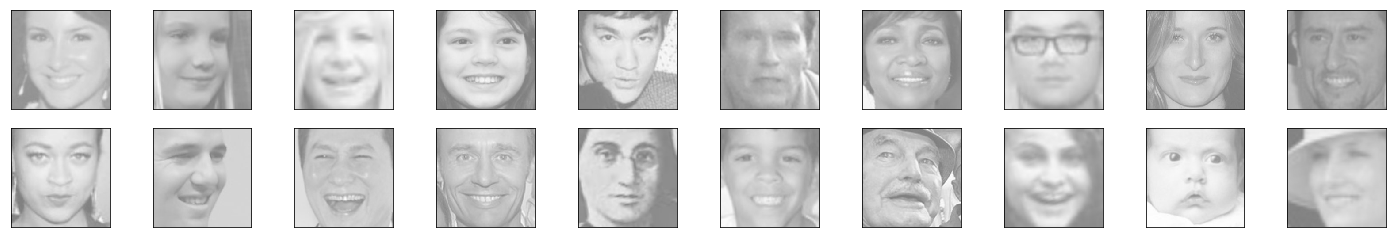

In [47]:
import torch
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as datasets
# Comment 0: define transformation that you wish to apply on image
data_transforms = transforms.Compose([
                    transforms.CenterCrop(224),
                    transforms.Grayscale(num_output_channels=3),
                    transforms.ToTensor()])
# Comment 1 : Load the datasets with ImageFolder
image_datasets = datasets.ImageFolder(root=  ROOT +"/train", transform=data_transforms)
# Comment 2: Using the image datasets and the transforms, define the dataloaders
dataloaders = torch.utils.data.DataLoader(image_datasets, batch_size=32, shuffle=True, num_workers=2)

# --- Plot all the images in the file
import matplotlib.pyplot as plt 
%matplotlib inline
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    
dataiter = iter(dataloaders)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])


##Import Necessary Packages


In [0]:
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.models import Model
from keras import backend as K
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np   # linear algebra
import keras
from keras.models import *
from keras.layers import *
from keras.preprocessing import *
from keras.callbacks import *
from keras.optimizers import *
from tqdm import tqdm
import glob
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sys
import cv2
from random import choice, sample
import datetime
from sklearn.metrics import roc_auc_score
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import threading

from keras.initializers import glorot_normal

import tensorflow as tf
import os

from numpy import genfromtxt
from keras.layers import Conv2D, ZeroPadding2D, Activation
from keras.layers.normalization import BatchNormalization


## Define Functions for Computing distances and Accuracy

Mostly used for the construction of BCNN layers


In [0]:

def outer_product(x):
    """
    calculate outer-products of 2 tensors

        args 
            x
                list of 2 tensors
                , assuming each of which has shape = (size_minibatch, total_pixels, size_filter)
    """
    return keras.backend.batch_dot(
                x[0]
                , x[1]
                , axes=[1,1]
            ) / x[0].get_shape().as_list()[1] 

def signed_sqrt(x):
    """
    calculate element-wise signed square root

        args
            x
                a tensor
    """
    return keras.backend.sign(x) * keras.backend.sqrt(keras.backend.abs(x) + 1e-9)

def L2_norm(x, axis=-1):
    """
    calculate L2-norm

        args 
            x
                a tensor
    """
    return keras.backend.l2_normalize(x, axis=axis)

def auc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

        
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    sqaure_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * sqaure_pred + (1 - y_true) * margin_square)

def create_base_network(input_shape):
    new_mod = Model(mod.input,mod.layers[-5].output)
    return new_mod

def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))


## Define Functions for Local Response Normalization and Batch Normalization


---
Normalization compensates for the unbounded nature of certain activation functions such as ReLU, ELU etc.
With these activation function, the output layers is not constrained within a bounded range (such as [-1,1] for tanh), rather they can grow as high as the training allows it. To limit the unbounded activation from increasing the output layer values, normalization is used just before the activation function.

###Local Response Normalization
Local Response Normalization (LRN) was first introduced in AlexNet architecture where the activation function used was ReLU as opposed to the more common tanh and sigmoid at that time. Apart from the reason mentioned above, the reason for using LRN was to **encourage lateral inhibition.** It is a concept in Neurobiology which refers to the capacity of a neuron to reduce the activity of its neighbors.
In DNNs, the purpose of this lateral inhibition is to carry out local contrast enhancement so that locally maximum pixels value are used as excitation for next layers.

###Batch Normalization:
Batch Normalization (BN) is a trainable layer normally used for **addressing the issues of Internal Covariance Shift** (ICF) - Covariance Shift for Hidden layers. ICF arises due to the changing distribution of the hidden neurons/activation. Covariate Shift can be mitigated by making sure that the members within a batch do not belong to same/similar distribution. This can be done by randomly selecting images for batches.


**Reference**: https://towardsdatascience.com/difference-between-local-response-normalization-and-batch-normalization-272308c034ac

In [0]:
def LRN2D(x):
    # Local Response Normalization: encourage lateral inhibition. 
    # It is a concept in Neurobiology which refers to the capacity of a neuron to reduce the activity of its neighbors
    return tf.nn.lrn(x, alpha=1e-4, beta=0.75)

def conv2d_bn(
    # Use for building conv2D with BatchNormalization
  x,
  layer=None,
  cv1_out=None,
  cv1_filter=(1, 1),
  cv1_strides=(1, 1),
  cv2_out=None,
  cv2_filter=(3, 3),
  cv2_strides=(1, 1),
  padding=None,
):
  
    """Utility function to apply conv + BN.
    # Arguments
        x: input tensor.
        filters: filters in `Conv2D`.
        num_row: height of the convolution kernel.
        num_col: width of the convolution kernel.
        padding: padding mode in `Conv2D`.
        strides: strides in `Conv2D`.
        name: name of the ops; will become `name + '_conv'`
            for the convolution and `name + '_bn'` for the
            batch norm layer.
    # Returns
        Output tensor after applying `Conv2D` and `BatchNormalization`.
    """
    
    num = '' if cv2_out == None else '1'
    tensor = Conv2D(cv1_out, cv1_filter, strides=cv1_strides, name=layer+'_conv'+num)(x)
    tensor = BatchNormalization(axis=3, epsilon=0.00001, name=layer+'_bn'+num)(tensor)
    tensor = Activation('relu')(tensor)
    if padding == None:
        return tensor
    tensor = ZeroPadding2D(padding=padding)(tensor)
    if cv2_out == None:
        return tensor
    tensor = Conv2D(cv2_out, cv2_filter, strides=cv2_strides, name=layer+'_conv'+'2')(tensor)
    tensor = BatchNormalization(axis=3, epsilon=0.00001, name=layer+'_bn'+'2')(tensor)
    tensor = Activation('relu')(tensor)
    return tensor

## Define functions for reading images and csv file for relationships

In [33]:
def read_img(im_path):
    im1 = image.load_img(im_path, target_size=(96, 96))
    im1 = image.img_to_array(im1)
    im1 = np.expand_dims(im1, axis=0)
    im1 = preprocess_input(im1,mode='tf')
    return im1[0]

from collections import defaultdict
#keeps all photos path in a dictionary
allPhotos = defaultdict(list)
for family in glob.glob(ROOT+"train/*"):
    for mem in glob.glob(family+'/*'):
        for photo in glob.glob(mem+'/*'):
            allPhotos[mem].append(photo)

#list of all members with valid photo
ppl = list(allPhotos.keys())
len(ppl)

data = pd.read_csv(ROOT+'train_relationships.csv')
data.p1 = data.p1.apply( lambda x: ROOT+'train/'+x )
data.p2 = data.p2.apply( lambda x: ROOT+'train/'+x )
print('data shape:')
print(data.shape)
data.head()

data = data[ ( (data.p1.isin(ppl)) & (data.p2.isin(ppl)) ) ]
data = [ ( x[0], x[1]  ) for x in data.values ]
len(data)

train = [ x for x in data if 'F09' not in x[0]  ]
val = [ x for x in data if 'F09' in x[0]  ]
len(train), len(val)

def getImages(p1,p2):
    p1 = read_img(choice(allPhotos[p1]))
    p2 = read_img(choice(allPhotos[p2]))
    return p1,p2

def getMiniBatch(batch_size=16, data=train):
    p1 = []; p2 = []; Y = []
    batch = sample(data, batch_size//2)
    for x in batch:
        _p1, _p2 = getImages(*x)
        p1.append(_p1);p2.append(_p2);Y.append(1)
    while len(Y) < batch_size:
        _p1,_p2 = tuple(np.random.choice(ppl,size=2, replace=False))
        if (_p1,_p2) not in train+val and (_p2,_p1) not in train+val:
            _p1,_p2 = getImages(_p1,_p2)
            p1.append(_p1);p2.append(_p2);Y.append(0) 
    return [np.array(p1),np.array(p2)], np.array(Y)


data shape:
(3598, 2)


## Define the Inception Model

---

The model is comprised of inception layers v1 summarized by the following:

![https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/10/Screenshot-from-2018-10-16-11-56-41.png](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/10/Screenshot-from-2018-10-16-11-56-41.png)

###Inception Layers:
Inception is a deep convolutional neural network architecture that was introduced in 2014. It won the ImageNet Large-Scale Visual Recognition Challenge (ILSVRC14). It was mostly developed by Google researchers and cited on the paper: **“Going Deeper with Convolutions”** by C.Szegedy et al.

We can see that Deeper/Bigger Neural Networks, can often create complications:

*   Bigger the model, more prone it is to overfitting. This is particularly noticeable when the training data is small
*   Increasing the number of parameters means you need to increase your existing computational resources

A solution for this, as the paper suggests, is to move on to sparsely connected network architectures which will replace fully connected network architectures, especially inside convolutional layers. It lets you maintain the “computational budget”, while increasing the depth and width of the network.

An Inception layer is a combination of all those layers (namely, 1×1 Convolutional layer, 3×3 Convolutional layer, 5×5 Convolutional layer) with their output filter banks concatenated into a single output vector forming the input of the next stage.

![https://i2.wp.com/s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/10/Screenshot-from-2018-10-17-11-14-10.png?resize=532%2C287&ssl=1](https://i2.wp.com/s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/10/Screenshot-from-2018-10-17-11-14-10.png?resize=532%2C287&ssl=1)

**Reference:** https://www.analyticsvidhya.com/blog/2018/10/understanding-inception-network-from-scratch/





In [0]:
def create_model():
    myInput = Input(shape=(96, 96, 3))

    x = ZeroPadding2D(padding=(3, 3), input_shape=(96, 96, 3))(myInput)
    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=3, epsilon=0.00001, name='bn1')(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D(pool_size=3, strides=2)(x)
    x = Lambda(LRN2D, name='lrn_1')(x)
    x = Conv2D(64, (1, 1), name='conv2')(x)
    x = BatchNormalization(axis=3, epsilon=0.00001, name='bn2')(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = Conv2D(192, (3, 3), name='conv3')(x)
    x = BatchNormalization(axis=3, epsilon=0.00001, name='bn3')(x)
    x = Activation('relu')(x)
    x = Lambda(LRN2D, name='lrn_2')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D(pool_size=3, strides=2)(x)

    # Inception3a
    inception_3a_3x3 = Conv2D(96, (1, 1), name='inception_3a_3x3_conv1')(x)
    inception_3a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_3x3_bn1')(inception_3a_3x3)
    inception_3a_3x3 = Activation('relu')(inception_3a_3x3)
    inception_3a_3x3 = ZeroPadding2D(padding=(1, 1))(inception_3a_3x3)
    inception_3a_3x3 = Conv2D(128, (3, 3), name='inception_3a_3x3_conv2')(inception_3a_3x3)
    inception_3a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_3x3_bn2')(inception_3a_3x3)
    inception_3a_3x3 = Activation('relu')(inception_3a_3x3)

    inception_3a_5x5 = Conv2D(16, (1, 1), name='inception_3a_5x5_conv1')(x)
    inception_3a_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_5x5_bn1')(inception_3a_5x5)
    inception_3a_5x5 = Activation('relu')(inception_3a_5x5)
    inception_3a_5x5 = ZeroPadding2D(padding=(2, 2))(inception_3a_5x5)
    inception_3a_5x5 = Conv2D(32, (5, 5), name='inception_3a_5x5_conv2')(inception_3a_5x5)
    inception_3a_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_5x5_bn2')(inception_3a_5x5)
    inception_3a_5x5 = Activation('relu')(inception_3a_5x5)

    inception_3a_pool = MaxPooling2D(pool_size=3, strides=2)(x)
    inception_3a_pool = Conv2D(32, (1, 1), name='inception_3a_pool_conv')(inception_3a_pool)
    inception_3a_pool = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_pool_bn')(inception_3a_pool)
    inception_3a_pool = Activation('relu')(inception_3a_pool)
    inception_3a_pool = ZeroPadding2D(padding=((3, 4), (3, 4)))(inception_3a_pool)

    inception_3a_1x1 = Conv2D(64, (1, 1), name='inception_3a_1x1_conv')(x)
    inception_3a_1x1 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_1x1_bn')(inception_3a_1x1)
    inception_3a_1x1 = Activation('relu')(inception_3a_1x1)

    inception_3a = concatenate([inception_3a_3x3, inception_3a_5x5, inception_3a_pool, inception_3a_1x1], axis=3)

    # Inception3b
    inception_3b_3x3 = Conv2D(96, (1, 1), name='inception_3b_3x3_conv1')(inception_3a)
    inception_3b_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_3x3_bn1')(inception_3b_3x3)
    inception_3b_3x3 = Activation('relu')(inception_3b_3x3)
    inception_3b_3x3 = ZeroPadding2D(padding=(1, 1))(inception_3b_3x3)
    inception_3b_3x3 = Conv2D(128, (3, 3), name='inception_3b_3x3_conv2')(inception_3b_3x3)
    inception_3b_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_3x3_bn2')(inception_3b_3x3)
    inception_3b_3x3 = Activation('relu')(inception_3b_3x3)

    inception_3b_5x5 = Conv2D(32, (1, 1), name='inception_3b_5x5_conv1')(inception_3a)
    inception_3b_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_5x5_bn1')(inception_3b_5x5)
    inception_3b_5x5 = Activation('relu')(inception_3b_5x5)
    inception_3b_5x5 = ZeroPadding2D(padding=(2, 2))(inception_3b_5x5)
    inception_3b_5x5 = Conv2D(64, (5, 5), name='inception_3b_5x5_conv2')(inception_3b_5x5)
    inception_3b_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_5x5_bn2')(inception_3b_5x5)
    inception_3b_5x5 = Activation('relu')(inception_3b_5x5)

    inception_3b_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_3a)
    inception_3b_pool = Conv2D(64, (1, 1), name='inception_3b_pool_conv')(inception_3b_pool)
    inception_3b_pool = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_pool_bn')(inception_3b_pool)
    inception_3b_pool = Activation('relu')(inception_3b_pool)
    inception_3b_pool = ZeroPadding2D(padding=(4, 4))(inception_3b_pool)

    inception_3b_1x1 = Conv2D(64, (1, 1), name='inception_3b_1x1_conv')(inception_3a)
    inception_3b_1x1 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_1x1_bn')(inception_3b_1x1)
    inception_3b_1x1 = Activation('relu')(inception_3b_1x1)

    inception_3b = concatenate([inception_3b_3x3, inception_3b_5x5, inception_3b_pool, inception_3b_1x1], axis=3)

    # Inception3c
    inception_3c_3x3 = conv2d_bn(inception_3b,
                                       layer='inception_3c_3x3',
                                       cv1_out=128,
                                       cv1_filter=(1, 1),
                                       cv2_out=256,
                                       cv2_filter=(3, 3),
                                       cv2_strides=(2, 2),
                                       padding=(1, 1))

    inception_3c_5x5 = conv2d_bn(inception_3b,
                                       layer='inception_3c_5x5',
                                       cv1_out=32,
                                       cv1_filter=(1, 1),
                                       cv2_out=64,
                                       cv2_filter=(5, 5),
                                       cv2_strides=(2, 2),
                                       padding=(2, 2))

    inception_3c_pool = MaxPooling2D(pool_size=3, strides=2)(inception_3b)
    inception_3c_pool = ZeroPadding2D(padding=((0, 1), (0, 1)))(inception_3c_pool)

    inception_3c = concatenate([inception_3c_3x3, inception_3c_5x5, inception_3c_pool], axis=3)

    #inception 4a
    inception_4a_3x3 = conv2d_bn(inception_3c,
                                       layer='inception_4a_3x3',
                                       cv1_out=96,
                                       cv1_filter=(1, 1),
                                       cv2_out=192,
                                       cv2_filter=(3, 3),
                                       cv2_strides=(1, 1),
                                       padding=(1, 1))
    inception_4a_5x5 = conv2d_bn(inception_3c,
                                       layer='inception_4a_5x5',
                                       cv1_out=32,
                                       cv1_filter=(1, 1),
                                       cv2_out=64,
                                       cv2_filter=(5, 5),
                                       cv2_strides=(1, 1),
                                       padding=(2, 2))

    inception_4a_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_3c)
    inception_4a_pool = conv2d_bn(inception_4a_pool,
                                        layer='inception_4a_pool',
                                        cv1_out=128,
                                        cv1_filter=(1, 1),
                                        padding=(2, 2))
    inception_4a_1x1 = conv2d_bn(inception_3c,
                                       layer='inception_4a_1x1',
                                       cv1_out=256,
                                       cv1_filter=(1, 1))
    inception_4a = concatenate([inception_4a_3x3, inception_4a_5x5, inception_4a_pool, inception_4a_1x1], axis=3)

    #inception4e
    inception_4e_3x3 = conv2d_bn(inception_4a,
                                       layer='inception_4e_3x3',
                                       cv1_out=160,
                                       cv1_filter=(1, 1),
                                       cv2_out=256,
                                       cv2_filter=(3, 3),
                                       cv2_strides=(2, 2),
                                       padding=(1, 1))
    inception_4e_5x5 = conv2d_bn(inception_4a,
                                       layer='inception_4e_5x5',
                                       cv1_out=64,
                                       cv1_filter=(1, 1),
                                       cv2_out=128,
                                       cv2_filter=(5, 5),
                                       cv2_strides=(2, 2),
                                       padding=(2, 2))
    inception_4e_pool = MaxPooling2D(pool_size=3, strides=2)(inception_4a)
    inception_4e_pool = ZeroPadding2D(padding=((0, 1), (0, 1)))(inception_4e_pool)

    inception_4e = concatenate([inception_4e_3x3, inception_4e_5x5, inception_4e_pool], axis=3)

    #inception5a
    inception_5a_3x3 = conv2d_bn(inception_4e,
                                       layer='inception_5a_3x3',
                                       cv1_out=96,
                                       cv1_filter=(1, 1),
                                       cv2_out=384,
                                       cv2_filter=(3, 3),
                                       cv2_strides=(1, 1),
                                       padding=(1, 1))

    inception_5a_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_4e)
    inception_5a_pool = conv2d_bn(inception_5a_pool,
                                        layer='inception_5a_pool',
                                        cv1_out=96,
                                        cv1_filter=(1, 1),
                                        padding=(1, 1))
    inception_5a_1x1 = conv2d_bn(inception_4e,
                                       layer='inception_5a_1x1',
                                       cv1_out=256,
                                       cv1_filter=(1, 1))

    inception_5a = concatenate([inception_5a_3x3, inception_5a_pool, inception_5a_1x1], axis=3)

    #inception_5b
    inception_5b_3x3 = conv2d_bn(inception_5a,
                                       layer='inception_5b_3x3',
                                       cv1_out=96,
                                       cv1_filter=(1, 1),
                                       cv2_out=384,
                                       cv2_filter=(3, 3),
                                       cv2_strides=(1, 1),
                                       padding=(1, 1))
    inception_5b_pool = MaxPooling2D(pool_size=3, strides=2)(inception_5a)
    inception_5b_pool = conv2d_bn(inception_5b_pool,
                                        layer='inception_5b_pool',
                                        cv1_out=96,
                                        cv1_filter=(1, 1))
    inception_5b_pool = ZeroPadding2D(padding=(1, 1))(inception_5b_pool)

    inception_5b_1x1 = conv2d_bn(inception_5a,
                                       layer='inception_5b_1x1',
                                       cv1_out=256,
                                       cv1_filter=(1, 1))
    inception_5b = concatenate([inception_5b_3x3, inception_5b_pool, inception_5b_1x1], axis=3)

    av_pool = AveragePooling2D(pool_size=(3, 3), strides=(1, 1))(inception_5b)
    reshape_layer = Flatten()(av_pool)
    dense_layer = Dense(128, name='dense_layer')(reshape_layer)
    norm_layer = Lambda(lambda  x: K.l2_normalize(x, axis=1), name='norm_layer')(dense_layer)

    return Model(inputs=[myInput], outputs=norm_layer)


## Create the Inception Model and Import Weights of Open Face



---

Load pretrained weights from pre-trained model of Keras-OpenFace:
https://github.com/iwantooxxoox/Keras-OpenFace.git

### Open Face
OpenFace is a Python and Torch implementation of face recognition with deep neural networks and is based on the CVPR 2015 paper FaceNet: A Unified Embedding for Face Recognition and Clustering by Florian Schroff, Dmitry Kalenichenko, and James Philbin at Google. Torch allows the network to be executed on a CPU or with CUDA. 

Available at: https://github.com/cmusatyalab/openface.git

<img src="https://raw.githubusercontent.com/cmusatyalab/openface/master/images/summary.jpg" width="600">

In [0]:
mod = create_model()
mod.load_weights(ROOT+'kin-detection/nn4.small2.v1.h5') # weights of keras-openface

## Create Checkpoints and Callbacks

---

For Callbacks Monitor Early Stopping and Reduction of Learning Rate

In [36]:
# Save best checkpoints   for the model
ModelCheckpoint('model_best_checkpoint.h5', save_best_only=True,
                                    save_weights_only=True, monitor='val_auc', mode='max', verbose=1)

In [37]:
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                           patience=8,
                           verbose=0,
                           min_delta=1e-4),
             keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=0,
                               epsilon=1e-4),
            keras.callbacks.ModelCheckpoint('model_best_checkpoint.h5',save_best_only=True,
                                            verbose=0, save_weights_only=True,monitor='val_auc',mode='max'),
        ]

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


## Create The Bilinear Convolutional Neural Network (BCNN)

###BCNNs
These networks represent an image as a pooled outer product of features derived from two CNNs and capture localized feature interactions in a translationally invariant manner. B-CNNs belong to the class of orderless texture representations but unlike prior work they can be trained in an end-to-end manner.

A recognition architecture that consists of two feature extractors whose outputs are multiplied using outer product at each location of the image and pooled to obtain an image descriptor.

Related to the two stream hypothesis of visual processing in the human brain.  The ventral stream (or, “what pathway”) is involved with object identification and recognition. The dorsal stream (or, “where pathway”) is involved with processing the object’s spatial location relative to the viewer

Available at: https://github.com/tkhs3/BCNN_keras.git


<img src="http://vis-www.cs.umass.edu/bcnn/docs/teaser-bcnn.png" width="800">

**Reference:** http://vis-www.cs.umass.edu/bcnn/


In [38]:

input_shape = (96,96,3)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# Loads the model from Open face to BCNN
base_network = create_base_network(input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)


# extract features from detector
x_detector = processed_a
shape_detector = processed_a.shape

# extract features from extractor , same with detector for symmetry DxD model
shape_extractor = processed_b.shape
x_extractor = processed_b

# rehape to (minibatch_size, total_pixels, filter_size)
x_detector = keras.layers.Reshape([shape_detector[1] * shape_detector[2] , shape_detector[-1]])(x_detector)
x_extractor = keras.layers.Reshape([shape_extractor[1] * shape_extractor[2] , shape_extractor[-1]])(x_extractor)

# outer products of features, output shape=(minibatch_size, filter_size_detector*filter_size_extractor)
x = keras.layers.Lambda(outer_product)([x_detector, x_extractor])

# rehape to (minibatch_size, filter_size_detector*filter_size_extractor)
x = keras.layers.Reshape([shape_detector[-1]*shape_extractor[-1]])(x)
# signed square-root 

x = keras.layers.Lambda(signed_sqrt)(x)
# L2 normalization
x = keras.layers.Lambda(L2_norm)(x)

### 
### attach FC-Layer
###

x = Dense(100, activation="relu")(x)
x = Dropout(0.01)(x)

out = Dense(units=1,kernel_regularizer=keras.regularizers.l2(1e-8),kernel_initializer='glorot_normal',activation="sigmoid")(x)

model = Model([input_a, input_b], out)

model.compile(loss="binary_crossentropy", metrics=['acc',auc], optimizer=Adam(0.001))

print(model.summary())

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
model_5 (Model)                 (None, 3, 3, 736)    3648944     input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
reshape_4 (Reshape)             (None, Dimension(9), 0           model_5[1][0]              

## Train the Network and Plot Validation/Training Losses and Accuracy


---

The Network is trained for 100 epochs but it early stopped at the 30th epoch

In [0]:
def Generator(batch_size, data ):
    while True:
        yield getMiniBatch(batch_size=batch_size, data=data)

train_gen = Generator(batch_size=16,data=train)
val_gen = Generator(batch_size=16,data=val)

history = model.fit_generator(train_gen,steps_per_epoch=200,use_multiprocessing=True,
          epochs=100,validation_data=val_gen,validation_steps=100,callbacks=callbacks, verbose = 0)

dict_keys(['val_loss', 'val_acc', 'val_auc', 'loss', 'acc', 'auc', 'lr'])


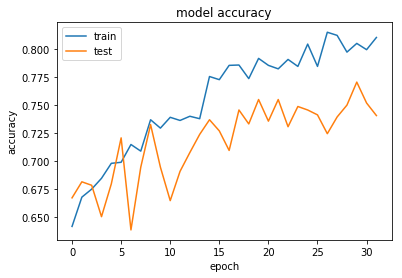

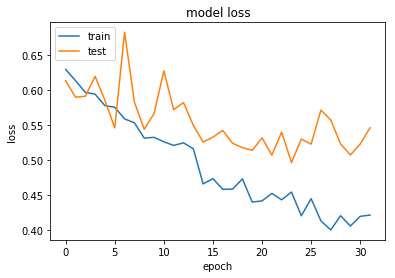

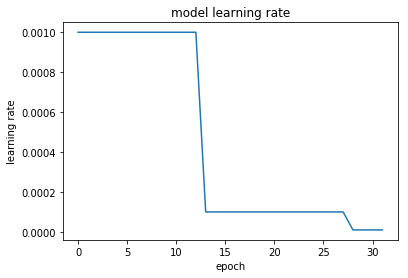

In [51]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['lr'])
plt.title('model learning rate')
plt.ylabel('learning rate')
plt.xlabel('epoch')
plt.show()

**Save Model and Weights:**

In [0]:
# save the model and weights

from google.colab import drive
drive.mount('/content/gdrive')

ROOT = '/content/gdrive/My Drive/SMILE_LAB_dataset/'

model.save_weights(ROOT+"saved_models_weights/model_weights.h5")
print("Saved model to drive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Saved model to drive


## Make Predictions

---

Upon submission in Kaggle it achieved the following scores:

|Private Score: |Public Score:  
----------------|--------------------------
|0.835          | 0.828

In [0]:
test_path = ROOT+"test/"

In [0]:
model.load_weights('model_best_checkpoint.h5')


In [0]:
def chunker(seq, size=32):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

from tqdm import tqdm

submission = pd.read_csv(ROOT+'sample_submission.csv')

predictions = []

In [0]:
predictions = []
for batch in tqdm(chunker(submission.img_pair.values)):
    X1 = [x.split("-")[0] for x in batch]
    X1 = np.array([read_img(test_path + x) for x in X1])

    X2 = [x.split("-")[1] for x in batch]
    X2 = np.array([read_img(test_path + x) for x in X2])

    pred = model.predict([X1, X2]).ravel().tolist()
    predictions += pred

166it [37:20,  9.84s/it]


In [0]:
submission['is_related'] = predictions

submission.to_csv(ROOT+"sumission 1.csv", index=False)